In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the data
train_data = pd.read_csv('/content/drive/MyDrive/Corona_NLP_train.csv', encoding='latin-1')
test_data = pd.read_csv('/content/drive/MyDrive/Corona_NLP_test.csv')

# Preprocess the data
def preprocess_data(data):
    data = data.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)
    return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

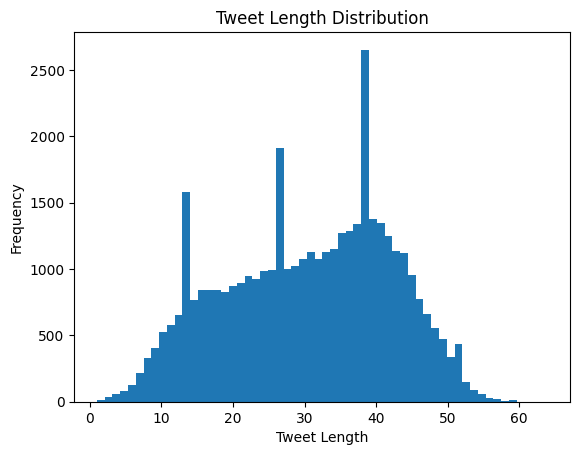

Suggested max_length: 48
Suggested vocab_size: 73621


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def analyze_tweet_lengths(texts):
    tweet_lengths = [len(t.split()) for t in texts]
    return tweet_lengths

def plot_length_histogram(lengths):
    plt.hist(lengths, bins='auto')
    plt.xlabel('Tweet Length')
    plt.ylabel('Frequency')
    plt.title('Tweet Length Distribution')
    plt.show()

def suggest_max_length(lengths, threshold=0.95):
    sorted_lengths = sorted(lengths)
    total_tweets = len(sorted_lengths)
    cumulative_sum = 0

    for i, length in enumerate(sorted_lengths):
        cumulative_sum += 1
        if cumulative_sum / total_tweets >= threshold:
            return length

def analyze_vocab_size(texts):
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())

    return len(word_counts)

def suggest_vocab_size(texts, threshold=0.95):
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())

    total_words = sum(word_counts.values())
    vocab_size = 0
    cumulative_sum = 0

    for word, count in word_counts.most_common():
        cumulative_sum += count
        vocab_size += 1
        if cumulative_sum / total_words >= threshold:
            return vocab_size

# Analyze the train_data
train_texts = train_data['OriginalTweet']

# Determine the optimal max_length
tweet_lengths = analyze_tweet_lengths(train_texts)
plot_length_histogram(tweet_lengths)
max_length = suggest_max_length(tweet_lengths)
print(f"Suggested max_length: {max_length}")

# Determine the optimal vocab_size
vocab_size = suggest_vocab_size(train_texts)
print(f"Suggested vocab_size: {vocab_size}")


In [ ]:
# Tokenize and pad the tweets
max_length = max_length
trunc_type = 'post'
padding_type = 'post'
vocab_size = vocab_size
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['OriginalTweet'])

train_sequences = tokenizer.texts_to_sequences(train_data['OriginalTweet'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_data['OriginalTweet'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [ ]:
# Encode the sentiment labels
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_data['Sentiment'])
test_labels = encoder.transform(test_data['Sentiment'])

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.2, random_state=42)


In [ ]:
# Build the model
embedding_dim = 128

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stop], batch_size=32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 128)           9423488   
                                                                 
 bidirectional (Bidirectiona  (None, 48, 256)          263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 3

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f"Test accuracy: {test_acc}")

# Make a prediction on a dummy tweet
dummy_tweet = "dont wear mask!"
dummy_seq = tokenizer.texts_to_sequences([dummy_tweet])
dummy_padded = pad_sequences(dummy_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

prediction = model.predict(dummy_padded)
predicted_label = encoder.inverse_transform([np.argmax(prediction)])

print(f"Dummy tweet sentiment: {predicted_label[0]}")

119/119 [==============================] - 1s 8ms/step - loss: 1.0101 - accuracy: 0.7433
Test accuracy: 0.7432859539985657
1/1 [==============================] - 0s 22ms/step
Dummy tweet sentiment: Neutral
